In [0]:
import numpy as np
import pandas as pd

# task 1.1
import torch
import torch.nn.functional as F
from torch import autograd

# task 1.2
from sklearn.datasets import load_digits
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
%matplotlib inline

# task 2 
import sklearn.datasets as sk_data
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

import torch.nn as nn
import torch.utils.data as torch_data
import torch.optim as optim
from torch.distributions.multivariate_normal import MultivariateNormal

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
 astrophysics		    mipt_lukoshkin.pdf		     uploads
'Colab Notebooks'	   'Scanbot 18 Dec 2019 19.18.pdf'   weights.pth
'Colab Notebooks_trashed'   Train_rev1.zip
 GKE.gslides		   'Untitled document.gdoc'


In [5]:
!mkdir -p data/kmnist
!cp /content/gdrive/My\ Drive/uploads/ml_hw3/* data/kmnist
!ls data/kmnist

kmnist-test-imgs.npz	kmnist-train-imgs.npz
kmnist-test-labels.npz	kmnist-train-labels.npz


# Home Assignment No. 2: Part 2 (Practice)
To solve this task, you will write a lot of code to try several deep learning methods.
* You are **HIGHLY RECOMMENDED** to read relevant documentation, e.g. for [python](https://docs.python.org/3/), [numpy](https://docs.scipy.org/doc/numpy/reference/), [matlpotlib](https://matplotlib.org/) and [pytorch](https://pytorch.org/). Also remember that seminars, lecture slides, [Google](http://google.com) and [StackOverflow](https://stackoverflow.com/) are your close friends during this course (and, probably, whole life?).

* To do this part of homework, you have to write **CODE** directly inside specified places inside notebook **CELLS**.

* In some problems you may be asked to provide short discussion of the results. In this cases you have to create **MARKDOWN** cell with your comments right after the your code cell.

* For every separate (sub)problem you can get only 0 points or maximal points for this (sub)problem. There are **NO INTERMEDIATE scores**. So make sure that you did everything required in the task

* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e. if the reviewer decides to execute `Kernel` -> `Restart Kernel and Run All Cells`, after all the computation he will obtain exactly the same solution (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest to fix random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.

* Your code must be clear to the reviewer. For this purpose, try to include neccessary comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY** without any additional comments.

## Task 1. Deep ANNs. (5 points)

### Task 1.1.  Activation functions. (1 point)
Plot the following [activation functions](https://pytorch.org/docs/master/nn.html#non-linear-activation-functions) using their PyTorch realizations and their derivatives using [autograd](https://pytorch.org/docs/stable/autograd.html) functionality `grad()`:
   
1. **(1 pt.)** Plot `ReLU`, `ELU` ($\alpha = 1$), `Softplus` ($\beta = 1$) and `Sign`, `Sigmoid`, `Softsign`, `Tanh`.
Which of these functions may be, and which - definitely, are a poor choise as an activation function in a neural network? Why?

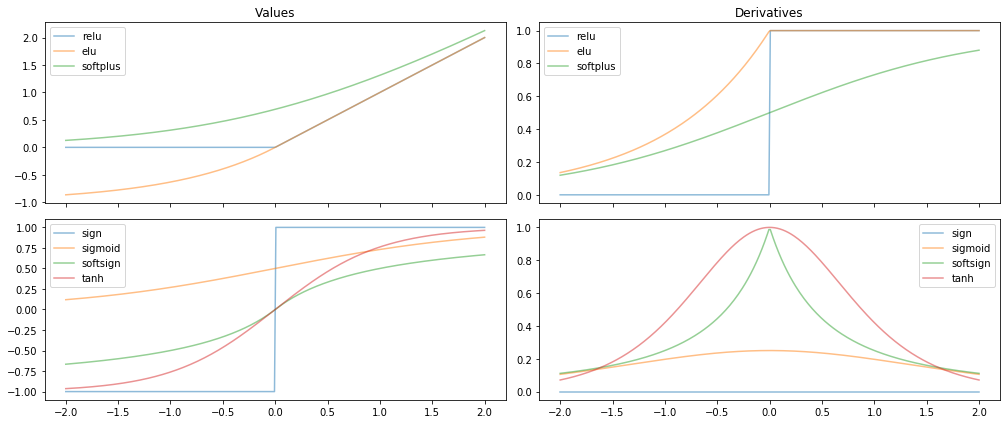

In [0]:
### BEGIN Solution
# >>> your solution here <<<
def D(y, x):
    grad = autograd.grad(
        outputs=y, inputs=x,
        grad_outputs=torch.ones_like(y))

    if len(grad) == 1:
        return grad[0]
    return grad.detach()

x = torch.linspace(-2, 2, 300, requires_grad=True)
x_data = x.detach().cpu()

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 6))
ax[0, 0].set_title('Values')
ax[0, 1].set_title('Derivatives')

relu_like = (torch.relu, F.elu, F.softplus)
sign_like = (torch.sign, torch.sigmoid, F.softsign, torch.tanh)

for i, fn_set in enumerate((relu_like, sign_like)):
    for fn in fn_set:
        ax[i, 0].plot(x_data, fn(x).detach(), label=fn.__name__, alpha=.5)
        ax[i, 1].plot(x_data, D(fn(x), x), label=fn.__name__, alpha=.5)

    ax[i, 0].legend()
    ax[i, 1].legend()

plt.tight_layout();
### END Solution

***Definitely not a good choice is `sign`, since it has zero derivative, and thus, a network containing this activation is untrainable***

What about the rest:
On the figure there are 2 groups of functions presented : relu- and sign-like (the contemplations below, on sign-like functions, do not apply to `sign` itself).

The former can suffer from gradient explosion, the latter from its vanishing. Moreover, neurons of high abs. value of input have close to zero derivatives, and are slowly being updated.

In the group of relu-like activations, relu is a poor choice. For ReLU, "*neurons arriving at large negative values cannot recover from being stuck at 0*" - this is called "*dying ReLU problem*"

When choosing an activation, one may also take into account such characteristics as continuity. Sometimes it matters, even for derivative of activation to be continuous (e.g. calculating grad penalties) 

### Task 1.2. MNIST classification. (4 points)

At the **[Seminar 13](https://github.com/adasegroup/ML2020_seminars/tree/master/seminar12)** on neural networks, we designed an MLP (Multilayer perceptron) with one hidden layer using our numpy implementations of linear layer, logistic and softmax activation functions. In this task, you are to

1. **(1 pt.)** Implement the MLP modules, including the Softmax cross entropy between `logits` and `labels`.
2. **(2 pt.)** Train our numpy realization of MLP to classify the MNIST from `sklearn.datasets()`. The required accuracy on validation is `> 90%`.
3. **(1 pt.)** Compare the acccuracy of classification to your scores from `Part 1` with and without dimensionality reduction. Is this comparison fair? :) Derive the confusion matrix for all digits classes. Which digits are predicted better or worse than others?

In [0]:
# fetch the dataset.
X, y = load_digits(return_X_y=True)
X = X.astype(np.float32) / 255

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0)

$\newcommand{\mat}[1]{\mathrm{mat}\left(#1\right)}$
$\newcommand{\vect}[1]{\mathrm{vec}\left(#1\right)}$

$$L = L(\hat Y, Y)$$
$$\hat Y = XW + b$$ 

$$\begin{array}{l}
    &X &\text{is of size} & m\times d\\
    &W &- &d\times p\\
    &b &- &p\\
    &Y &- &m \times p
\end{array}$$

---
$$
    \underset{m\times d}{\frac{\partial L}{\partial X}}
    = \underset{m\times p}{\frac{\partial L}{\partial\hat Y}}
    \;\;\circ\underbrace{\underset{mp\times md}{\frac{\partial\hat Y}{\partial X}}}
    _{\;\text{jacobian}\\\text{of Y wrt X}}
$$

Define the operation $\circ$ in such a way that it preserves dimensions

$$
    \underset{m\times d}{\frac{\partial L}{\partial X}}
    = \mat{\underset{md\times mp}{\left(\frac{\partial\hat Y}{\partial X}\right)^\top}
    \underset{mp}{\vect{\frac{\partial L}{\partial\hat Y}}}} \qquad (*)
$$

Take derivative of $\hat Y$ wrt X (applying the $\alpha$-derivative rule as stated [here](https://www.sciencedirect.com/science/article/pii/S0047259X10001120)):

$$
    \frac{\partial\hat Y}{\partial X} = \frac{\partial\vect{XW}}{\partial\vect{X}}
$$

Here we have thrown out the bias term since it does not depend on X

Consider the numerator:

$$
   \vect{I_mXW} = (W^\top\otimes I_m)\vect{X} 
$$

That is:

$$
    \frac{\partial\hat Y}{\partial X} = (W^\top\otimes I_m)^\top = W\otimes I_m
$$

Substituting the last expression into $(*)$, we obtain:

$$
    \frac{\partial L}{\partial X} = \mat{(W\otimes I_m)\vect{\frac{\partial L}{\partial\hat Y}}}
    = \mat{\vect{\frac{\partial L}{\partial\hat Y}W^\top}}
$$

$$
    \boxed{\frac{\partial L}{\partial X} = \frac{\partial L}{\partial\hat Y}W^\top}
$$

(See the [properties of Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) I used for the derivation)

---
Similarly for $\frac{\partial L}{\partial W}$:
$$
    \underset{d\times p}{\frac{\partial L}{\partial W}}
    = \underset{m\times p}{\frac{\partial L}{\partial\hat Y}}
    \;\;\circ\underbrace{\underset{mp\times dp}{\frac{\partial\hat Y}{\partial W}}}
    _{\;\text{jacobian}\\\text{of Y wrt W}}
$$

$$
    \underset{d\times p}{\frac{\partial L}{\partial W}}
    = \mat{\underset{dp\times mp}{\left(\frac{\partial\hat Y}{\partial W}\right)^\top}
    \underset{mp}{\vect{\frac{\partial L}{\partial\hat Y}}}}
$$

$$
    \vect{XWI_p} = (I_p\otimes X)\vect{W}
$$

$$
    \frac{\partial L}{\partial W}
    = \mat{(I_p\otimes X^\top)\vect{\frac{\partial L}{\partial\hat Y}}}
    = \mat{\vect{X^\top\frac{\partial L}{\partial\hat Y}}}
$$

$$
    \boxed{\frac{\partial L}{\partial W}
    = {X^\top\frac{\partial L}{\partial\hat Y}}}
$$

---
An easier way (this is not the case in general) to calculate the target derivatives is $\omega$-differentiation:

$$
    \frac{\partial L}{\partial X_{pq}} = \frac{\partial L}{\partial\hat Y_{ij}}
    \frac{\partial\hat Y_{ij}}{\partial X_{pq}}
$$

$$
    \frac{\partial\hat Y_{ij}}{\partial X_{pq}}
    = \frac{\partial X_{ik}}{\partial X_{pq}}W_{kj}
    = \delta_{ip}\delta_{kq} W_{kj}
$$

Substituting back:

$$
    \frac{\partial L}{\partial X_{pq}}
    = \frac{\partial L}{\partial\hat Y_{pj}}W_{qj}
    = \frac{\partial L}{\partial\hat Y_{pj}}W_{jq}^\top
$$

Hence
$$
    \boxed{\frac{\partial L}{\partial X}
    = \frac{\partial L}{\partial\hat Y}W^\top}
$$

$$
    \frac{\partial L}{\partial W_{pq}} = \frac{\partial L}{\partial\hat Y_{ij}}
    \frac{\partial\hat Y_{ij}}{\partial W_{pq}}
$$

$$
    \frac{\partial\hat Y_{ij}}{\partial W_{pq}}
    = X_{ik}\frac{\partial W_{kj}}{\partial W_{pq}}
    = X_{ik}\delta_{kp}\delta_{jq}
$$


$$
    \frac{\partial L}{\partial W_{pq}}
    = \frac{\partial L}{\partial\hat Y_{iq}}X_{ip}
    = X_{pi}^\top\frac{\partial L}{\partial\hat Y_{iq}}
$$

$$
    \boxed{\frac{\partial L}{\partial X}
    = X^\top\frac{\partial L}{\partial\hat Y}}
$$

---
$$
    \frac{\partial L}{\partial b_k}
    = \frac{\partial L}{\partial Y_{ij}}\frac{\partial Y_{ij}}{\partial b_k}
$$

$$
    \frac{\partial Y_{ij}}{\partial b_k}
    = \frac{\partial b_j}{\partial b_k} = \delta_{jk}
$$

$$
    \frac{\partial L}{\partial b_k}
    = \sum_i\frac{\partial L}{\partial Y_{ik}}
$$

$$
    \frac{\partial L}{\partial b}
    = \mathrm{sum}(\frac{\partial L}{\partial\hat Y}, \;\text{axis}=0)
$$

**Implement the MLP with backprop.**

In [0]:
# Here you should implement by yourself MLP class and its constituents
# including forward and backward propagation methods

class Linear:
    def __init__(self, input_size, output_size):
        self.W = np.random.randn(input_size, output_size)
        self.gradW = np.empty_like(self.W)
        self.b = np.random.randn(output_size)
        self.gradb = np.empty_like(self.b)
        
    def zeroGrad(self):
        self.gradW.fill(0.)
        self.gradb.fill(0.)
        
    def updateWeights(self, lr):
        self.W -= lr*self.gradW
        self.b -= lr*self.gradb

    def forward(self, X): 
        output = X @ self.W + self.b
        return output
    
    def backward(self, X, output_grad):
        """
        Returns gradient of the loss w.r.t. the input of linear layer
        Also updates gradients of layer parameters.
        """
        ### BEGIN Solution
        # ... calculate grads
        # >>> your solution here <<<
        self.gradW += X.T @ output_grad
        self.gradb += output_grad.sum(0)
        input_grad = output_grad @ self.W.T
        ### END Solution
        return input_grad
    

class LogisticActivation:
    def forward(self, x):
        output = 1/(1 + np.exp(-x))
        return output

    def backward(self, x, output_grad):
        """
        Returns the gradient of the loss w.r.t. the input
        """
        ### BEGIN Solution
        # >>> your solution here <<<
        input_grad = output_grad * self.forward(x)*(1-self.forward(x))
        ### END Solution
        return input_grad


class MLP:
    def __init__(self, input_size, hidden_layer_size, output_size):
        self.linear1 = Linear(input_size, hidden_layer_size)
        self.activation1 = LogisticActivation()
        self.linear2 = Linear(hidden_layer_size, output_size)
        self.attr_seq = ['linear1', 'activation1', 'linear2']
        self.inputs = []
        
    def zeroGrad(self):
        for attr in self.attr_seq:
            layer = getattr(self, attr)
            if getattr(layer, 'zeroGrad', None):
                layer.zeroGrad()
                
    def updateWeights(self, lr=1e-3):
        self.linear1.updateWeights(lr)
        self.linear2.updateWeights(lr)
        
    def forward(self, x):
        del self.inputs[:]
        for attr in self.attr_seq:
            self.inputs.append(x)
            layer = getattr(self, attr)
            x = layer.forward(x)
        return x

    def backward(self, output_grad):
        """
        Returns the gradient of the loss w.r.t. the input of MLP
        given the input and the gradient  w.r.t. output of MLP
        """
        ### BEGIN Solution
        # >>> your solution here <<<
        for attr, x in zip(self.attr_seq[::-1], self.inputs[::-1]):
            layer = getattr(self, attr)
            output_grad = layer.backward(x, output_grad)
        ### END Solution
        return output_grad

In derivation of the formulae below, we take into account, that $\mathbf t$-s are one-hot encoded true labels
$$\begin{gather}
    \mathrm{CE} = -\sum_i^C t_i \log\left(\frac{e^{s_i}}{\sum_j^C e^{s_j}}\right)
    = -\sum_i^C t_i \left(s_i - \log\sum_j^C e^{s_j}\right)\\
    = -\sum_{p\in P}\left(s_p - \log\sum_j^C e^{s_j}\right)
    = -\sum_{p\in P}\mathrm{logsoftmax}(s)[\text{slice}(p\in P)]
\end{gather}$$


$$\begin{gather}
    \frac{\partial \mathrm{CE}}{\partial s_k}
    = -\sum_i^C t_i \left(\delta_{ik} - \frac{e^{s_j}}{\sum_j^C e^{s_j}}\delta_{jk}\right)
    = -t_k + \frac{e^{s_k}}{\sum_j^C e^{s_j}}\underbrace{\sum_i^C t_i}_{=1}
    = -t_k + \mathrm{softmax}(s)_k\\
    \frac{\partial \mathrm{CE}}{\partial s} = \mathrm{softmax}(s) - t
\end{gather}$$

In [0]:
### BEGIN Solution
# Implement Cross Entropy Loss
def softmax(logits):
    out = logits - logits.max(axis=1, keepdims=True)
    np.exp(out, out=out)
    np.divide(out, out.sum(1, keepdims=True), out=out)
    return out

def logsoftmax(logits):
    out = logits - logits.max(axis=1, keepdims=True)
    out -= np.log(np.sum(np.exp(out), 1, keepdims=True))
    return out 

class CrossEntropyLoss:
    def __call__(self, logits, target):
        logprobs = logsoftmax(logits)
        return -logprobs[np.arange(len(target)), target.argmax(1)].mean()
    
    def backward(self, logits, target):
        return (softmax(logits) - target)/len(target)
### END Solution

In [0]:
def one_hot_encode(targets, n_classes):
    code = np.zeros((len(targets), n_classes), dtype='int8')
    code[np.arange(len(targets)), targets] = 1
    return code

y_train_1hot = one_hot_encode(y_train, 10)
y_test_1hot = one_hot_encode(y_test, 10)

def get_batches(n_samples, batch_size):
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for i in range(0, n_samples, batch_size):
        yield indices[i:i+batch_size]

In [0]:
np.random.seed(42)

mlp = MLP(input_size=8*8, hidden_layer_size=100, output_size=10)
CE = CrossEntropyLoss()

n_epochs = 100
pp = n_epochs // 10
learning_curve = [0] * n_epochs
test_curve = [0] * n_epochs

lr = 1e-1
N = len(y_train)
for epoch in range(n_epochs):
    epoch_loss = 0
    for k, ids in enumerate(get_batches(N, 10), 1):
        b_x, b_y = X_train[ids], y_train_1hot[ids]
        ### BEGIN Solution
        # ... zero the gradients of the model
        # ... perform forward pass and compute the loss
        # >>> your solution here <<<
        mlp.zeroGrad()
        logits = mlp.forward(b_x)
        
        # ... compute the gradients w.r.t. the input of softmax layer
        # ... and update the weights with weight -= grad * learning_rate
        # >>> your solution here <<<
        epoch_loss += CE(logits, b_y) * len(b_y)/N
        grad_output = CE.backward(logits, b_y)
        mlp.backward(grad_output)
        mlp.updateWeights(lr)
    learning_curve[epoch] = epoch_loss
    
    # Validation
    logits = mlp.forward(X_test)
    test_curve[epoch] = CE(logits, y_test_1hot).mean()
    y_pred = logits.argmax(axis=1)
    acc = accuracy_score(y_test, y_pred)

    if epoch % pp == 0:
        print(f'Starting epoch {epoch}.\nAccuracy on test: {acc}')
        print()
        
    ### END Solution

Starting epoch 0.
Accuracy on test: 0.10444444444444445

Starting epoch 10.
Accuracy on test: 0.5822222222222222

Starting epoch 20.
Accuracy on test: 0.8111111111111111

Starting epoch 30.
Accuracy on test: 0.8422222222222222

Starting epoch 40.
Accuracy on test: 0.9044444444444445

Starting epoch 50.
Accuracy on test: 0.86

Starting epoch 60.
Accuracy on test: 0.9022222222222223

Starting epoch 70.
Accuracy on test: 0.9311111111111111

Starting epoch 80.
Accuracy on test: 0.9333333333333333

Starting epoch 90.
Accuracy on test: 0.9266666666666666



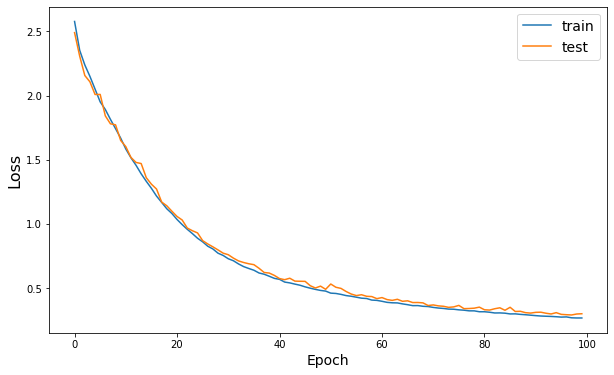

In [0]:
plt.figure(figsize=(10,6))
plt.plot(learning_curve, label='train')
plt.plot(test_curve, label='test')
plt.ylabel('Loss', size=16)
plt.xlabel('Epoch', size=14)
plt.legend(fontsize=14);

In [0]:
# confusion matrix
# >>> your solution here <<<
y_pred = mlp.forward(X).argmax(1)
pd.DataFrame(confusion_matrix(y, y_pred))

,0,1,2,3,4,5,6,7,8,9
0,177,0,0,0,1,0,0,0,0,0
1,0,154,2,0,2,0,3,0,4,17
2,0,2,172,1,0,0,0,0,0,2
3,0,1,2,165,0,2,0,3,3,7
4,0,0,0,0,176,0,0,1,0,4
5,0,0,0,0,1,166,1,0,0,14
6,1,2,0,0,1,0,177,0,0,0
7,0,0,0,0,2,0,0,174,0,3
8,0,11,1,0,2,3,1,0,147,9
9,0,0,0,1,1,2,0,0,0,176


## Task 2. Autoencoders. (7 points)

### Task 2.1.  Autoencoder on the tabular data. (3 points)


We will build a latent representation for tabular data with simple Autoencoder (AE). We are going to work with the cancer dataset from scikit-learn package. You are to follow the instructions `1.0 - 1.6`.  

1. **(1 pt.)** Implement AE modules;
2. **(2 pt.)** Train AE to get latent representation of the cancer dataset from `sklearn.datasets()`. Use `MSE` loss and get < $0.28$ on validation, with AE "bottleneck" = $2$;
3. **(1 pt.)** Plot the latent representation of whole dataset in 2D, use colors to show object of differneet classes;

#### 1.0 Featch the data. Scale it and split on train and test.

In [0]:
cancer_dset = sk_data.load_breast_cancer()

X = StandardScaler().fit_transform(cancer_dset['data'])

print('Features: ', list(cancer_dset['feature_names']))
print('\nShape:', X.shape)

X_train, X_val, y_train, y_val = train_test_split(X, cancer_dset['target'], test_size=0.2, random_state=42)
print('\nTrain size: ', len(X_train))
print('Validation size: ', len(X_val))

Features:  ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']

Shape: (569, 30)

Train size:  455
Validation size:  114


#### 1.1 Let us firtly create the dataset, which we'll be able to use with pytorch dataloader. 
Implement `__len__` and `__getitem__` methods.

In [0]:
class CancerData(torch_data.Dataset):
    def __init__(self, X, y):
        super(CancerData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        # >>> your solution here <<<
        return len(self.y) 
    
    def __getitem__(self, idx):
        # >>> your solution here <<<
        return self.X[idx], self.y[idx]

In [0]:
train_dset = CancerData(X_train, y_train) 
val_dset = CancerData(X_val, y_val) 

print(train_dset[5])

(tensor([ 0.1172,  1.9199,  0.1961,  0.0111,  1.2482,  1.0453,  0.9429,  0.6376,
         1.7940,  1.1302, -0.1269, -0.3336,  0.0064, -0.1713, -0.4780,  0.9458,
         0.5145, -0.1454, -0.2388,  0.6321,  0.2466,  1.8650,  0.5016,  0.1101,
         1.5532,  2.5664,  2.0649,  0.8617,  2.1310,  2.7793]), tensor(0.))


#### 1.2 Now, we'll make a base class for our autoencoder. 
AE takes as input encoder and decoder (it will be two neural networks). Your task is to implement the forward pass.

In [0]:
class MyFirstAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(MyFirstAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        """
        Take a mini-batch as an input,
        encode it to the latent space 
        and decode back to the original space
        
        x_out = decoder(encoder(x))
        :param x: torch.tensor, (MB, x_dim)
        :return: torch.tensor, (MB, x_dim)
        """
        # >>> your solution here <<<
        return self.decoder(self.encoder(x))

#### 1.3 It is high time to create encoder an decoder neural networks!
Make hidden size of the network to be equal to `2`.

**Hint.** You can use `nn.Sequential` to create your own archtectures.

In [0]:
# >>> your solution here <<<
class Encoder(nn.Module):
    def __init__(self, code_size):
        super().__init__()
        bw = 16
        self.conv1 = nn.Conv1d(1,bw,9,3, bias=False)
        # (30 - 9) / 3 + 1 = 8
        self.conv2 = nn.Conv1d(bw,2*bw,4,2, bias=False)
        # (8 - 4) / 2 + 1 = 3
        self.conv3 = nn.Conv1d(2*bw,4*bw,3, bias=False)
        # 3 - 3 + 1 = 1
        
        self.leaky = nn.LeakyReLU(inplace=True)
        self.fc = nn.Linear(4*bw, code_size)
        self.drop = nn.Dropout(.15)
        
        self.bn1 = nn.BatchNorm1d(bw)
        self.bn2 = nn.BatchNorm1d(bw*2)
        self.bn3 = nn.BatchNorm1d(bw*4)
        
    def forward(self, X):
        H = X[:, None]
        H = self.leaky(self.bn1(self.conv1(H)))
        H = self.drop(H)
        H = self.leaky(self.bn2(self.conv2(H)))
        H = self.drop(H)
        H = self.leaky(self.bn3(self.conv3(H)))
        H = self.drop(H)
        return self.fc(H.squeeze(-1))

# >>> your solution here <<<
decoder = lambda n: nn.Sequential(
    nn.Linear(n, 11),
    nn.LeakyReLU(inplace=True),
    nn.Linear(11, X.shape[1]))

In [0]:
# >>> your solution here <<<
device = 'cpu'

net = MyFirstAE(Encoder(2), decoder(2))
net = net.to(device)

criterion = nn.MSELoss()
# >>> your solution here <<<
optimizer = optim.Adam(net.parameters(), lr=3e-2)
# >>> your solution here <<<
scheduler = optim.lr_scheduler.StepLR(optimizer, 3, 0.994)

train_loader = torch_data.DataLoader(train_dset, batch_size=140, shuffle=True) 
val_loader = torch_data.DataLoader(val_dset, batch_size=200, shuffle=False) 

#### 1.4 Implement the missing parts of the `train` function

In [0]:
def train(
    epochs, net, criterion, optimizer, train_loader, val_loader,
    scheduler=None, verbose=True, save_dir=None):
    
    for epoch in range(1, epochs+1):
        net.train()
        train_loss = val_loss = 0
        for X, _ in train_loader:
            # Perform one step of minibatch stochastic GD
            # >>> your solution here <<<
            optimizer.zero_grad()
            
            X = X.to(device)
            loss = criterion(net(X), X)
            loss.backward()
            train_loss += loss.item() * len(X)/len(train_loader.dataset)
            
            optimizer.step()
        
        # define NN evaluation, i.e. turn off dropouts, batchnorms, etc.
        net.eval()
        for X, _ in val_loader:
            # Compute the validation loss
            # >>> your solution here <<<
            X = X.to(device)
            loss = criterion(net(X), X)
            val_loss += loss.item() * len(X)/len(val_loader.dataset)
         
        if scheduler is not None:
            scheduler.step()
        freq = max(epochs//20,1)
        if verbose and epoch%freq==0:
            print(
                f'Epoch {epoch}/{epochs} || Loss:'
                f'Train {train_loss:.4} | Validation {val_loss:.4f}')

#### 1.5 Train your AE on breast cancer dataset. 
Your goal is to get validation error < 0.3.

Some features that may help you to improve the performance:
* `Dropout`
* `Batchnorm`
* lr scheduler
* Batch size increase/decrease

In [0]:
# for `MSE` loss get < 0.28 on validation, with AE "bottleneck" = 2
torch.manual_seed(3)
train(800, net, criterion, optimizer, train_loader, val_loader, scheduler) 

Epoch 40/800 || Loss:Train 0.3594 | Validation 0.3291
Epoch 80/800 || Loss:Train 0.3416 | Validation 0.3118
Epoch 120/800 || Loss:Train 0.3259 | Validation 0.3105
Epoch 160/800 || Loss:Train 0.3288 | Validation 0.2927
Epoch 200/800 || Loss:Train 0.3208 | Validation 0.2878
Epoch 240/800 || Loss:Train 0.3069 | Validation 0.2877
Epoch 280/800 || Loss:Train 0.3055 | Validation 0.2864
Epoch 320/800 || Loss:Train 0.303 | Validation 0.2818
Epoch 360/800 || Loss:Train 0.2968 | Validation 0.2968
Epoch 400/800 || Loss:Train 0.3109 | Validation 0.2861
Epoch 440/800 || Loss:Train 0.2945 | Validation 0.2870
Epoch 480/800 || Loss:Train 0.2863 | Validation 0.2813
Epoch 520/800 || Loss:Train 0.2819 | Validation 0.2832
Epoch 560/800 || Loss:Train 0.283 | Validation 0.2858
Epoch 600/800 || Loss:Train 0.2928 | Validation 0.2780
Epoch 640/800 || Loss:Train 0.2899 | Validation 0.2861
Epoch 680/800 || Loss:Train 0.2844 | Validation 0.2812
Epoch 720/800 || Loss:Train 0.2834 | Validation 0.2791
Epoch 760/800 

#### 1.6 Let us take a look at the latent space. 
Encode the whole dataset, using your AE, plot it in 2D and use colors to indicate objects of differrent classes

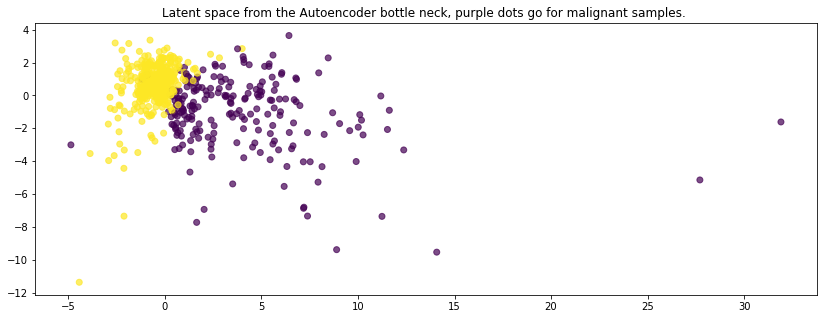

In [0]:
 ### BEGIN Solution
plt.figure(figsize=(14, 5))
net.eval()
enc = net.encoder(torch.Tensor(X)).detach()
plt.scatter(enc[:,0], enc[:,1], c=cancer_dset['target'], alpha=0.7);
plt.title('Latent space from the Autoencoder bottle neck, purple dots go for malignant samples. ');
 ### END Solution

### Task 2.2.  Autoencoder on kMNIST. (4 points)


We will build a latent representation for `kMRIST` dataset by using our AE. We will work with the data from `Part 1`.

1. **(2 pt.)** Train AE to get latent representation of the `kMNIST` dataset from `sklearn.datasets()`. Follow the instructions `2.0 - 2.4`. Use `MSE` loss and obtain < $0.035$ on validation, with AE "bottleneck"  $\leq 40$;
2. **(1 pt.)** Plot 10 images and their reconstructions. Plot the latent representation of the whole dataset in 3D, compare visually to your manifold from `Part 1` and upload (pictures) screenshots to this notebook.
3. **(1 pt.)** Get the classification accuracy for the latent features. Use the `KNN` classifier with any hyperparameters you like. Write a couple of sentences about the differences of `manifold learning` and ` AE` results. 
3. **(BONUS 3 pt.)** Sampling from latent representation.

In [0]:
def load(f):
    return np.load(f)['arr_0']

# Load the data
x_train = load('data/kmnist/kmnist-train-imgs.npz')
x_test = load('data/kmnist/kmnist-test-imgs.npz')
y_train = load('data/kmnist/kmnist-train-labels.npz')
y_test = load('data/kmnist/kmnist-test-labels.npz')

# Reshape the data and scale
x_train = x_train.astype('f4') / 255
x_test = x_test.astype('f4') / 255

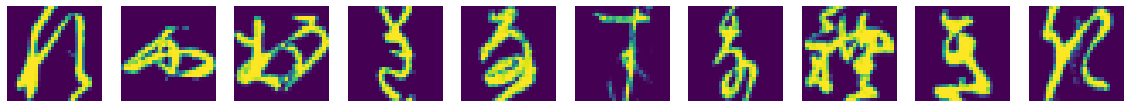

In [5]:
fig, ax = plt.subplots(ncols=10, figsize=(20, 5))
for i in range(10):
    ax[i].imshow(x_train[i]);
    ax[i].axis('off')

In [0]:
class kMNISTData(torch_data.Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [0]:
train_kmnist = kMNISTData(x_train, y_train)
test_kmnist = kMNISTData(x_test, y_test)

#### 2.0 Create encoder and decoder network for kMNIST. 
You can either use convolutions or flatten the images and use linear layers. You can choose hidden size (not larger than 40) and any architecture you like.

In [0]:
# >>> your solution here <<<
bw = 32
class Encoder(nn.Module):
    def __init__(self, code_size):
        super().__init__()
        # image size 28 x 28
        self.conv1 = nn.Conv2d(1, bw, 3, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(bw, 2*bw, 3, 2, 1, bias=False)
        self.conv3 = nn.Conv2d(2*bw, 4*bw, 3, 2, 1, bias=False)
        
        self.elu = nn.ELU(inplace=True)
        self.leaky = nn.LeakyReLU(inplace=True)
        self.fc = nn.Linear(4*bw*4*4, code_size)
        self.drop = nn.Dropout2d(.15)
        
        self.bn1 = nn.BatchNorm2d(bw)
        self.bn2 = nn.BatchNorm2d(bw*2)
        self.bn3 = nn.BatchNorm2d(bw*4)
        
    def forward(self, X):
        H = X[:, None]
        H = self.leaky(self.bn1(self.conv1(H)))
        H = self.drop(H)
        H = self.leaky(self.bn2(self.conv2(H)))
        H = self.drop(H)
        H = self.leaky(self.bn3(self.conv3(H)))
        H = self.drop(H)
        return self.fc(H.view(-1, 4*bw*4*4))

# >>> your solution here <<<
class Decoder(nn.Module):
    def __init__(self, code_size):
        super().__init__()
        self.fc = nn.Linear(code_size, 4*bw*4*4)
        self.leaky = nn.LeakyReLU(inplace=True)
        self.up1 = nn.ConvTranspose2d(4*bw, 2*bw, 3, 2, 1)
        self.up2 = nn.ConvTranspose2d(2*bw, bw, 4, 2, 1)
        self.up3 = nn.ConvTranspose2d(bw, 1, 4, 2, 1)
        
    def forward(self, X):
        H = self.leaky(self.fc(X))
        H = self.leaky(self.up1(H.view(-1, 4*bw, 4, 4)))
        H = self.leaky(self.up2(H))
        return torch.sigmoid(self.up3(H)).squeeze(1)

#### 2.1 Train AE on the kMNIST. 
Your goal is to obtain MSE on the test set < $0.035$ on `MyFirstAE(encoder(40), decoder(40))`.

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = MyFirstAE(Encoder(40), Decoder(40)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, 3, 0.99)

train_loader = torch_data.DataLoader(train_kmnist, batch_size=500, shuffle=True) 
val_loader = torch_data.DataLoader(test_kmnist, batch_size=500, shuffle=False) 

In [35]:
# If losses are not decreasing reload this cell and the one above
epochs = 50
train(epochs, net, criterion, optimizer, train_loader, val_loader, scheduler)

Epoch 2/50 || Loss:Train 0.032 | Validation 0.0282
Epoch 4/50 || Loss:Train 0.02222 | Validation 0.0229
Epoch 6/50 || Loss:Train 0.01992 | Validation 0.0217
Epoch 8/50 || Loss:Train 0.01875 | Validation 0.0208
Epoch 10/50 || Loss:Train 0.01807 | Validation 0.0207
Epoch 12/50 || Loss:Train 0.01778 | Validation 0.0193
Epoch 14/50 || Loss:Train 0.01729 | Validation 0.0191
Epoch 16/50 || Loss:Train 0.01703 | Validation 0.0189
Epoch 18/50 || Loss:Train 0.01672 | Validation 0.0187
Epoch 20/50 || Loss:Train 0.01658 | Validation 0.0200
Epoch 22/50 || Loss:Train 0.01635 | Validation 0.0183
Epoch 24/50 || Loss:Train 0.01616 | Validation 0.0181
Epoch 26/50 || Loss:Train 0.01615 | Validation 0.0181
Epoch 28/50 || Loss:Train 0.01588 | Validation 0.0180
Epoch 30/50 || Loss:Train 0.01583 | Validation 0.0180
Epoch 32/50 || Loss:Train 0.0157 | Validation 0.0178
Epoch 34/50 || Loss:Train 0.0155 | Validation 0.0179
Epoch 36/50 || Loss:Train 0.01551 | Validation 0.0177
Epoch 38/50 || Loss:Train 0.0154 | V

#### 2.2 Plot any 10 images and their reconstructions.

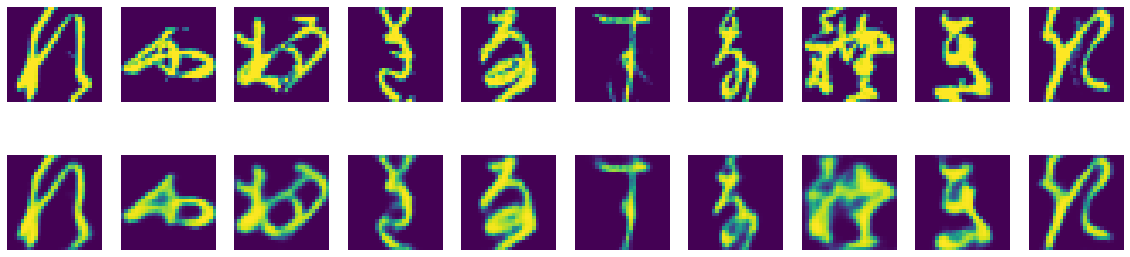

In [83]:
fig, ax = plt.subplots(ncols=10, nrows=2, figsize=(20, 5))
for i in range(10):
    im = train_kmnist[i][0]
    rec = net(torch.Tensor(im)[None].to(device)).squeeze(0).detach().cpu()
    ax[0, i].imshow(im);
    ax[1, i].imshow(rec);
    ax[0, i].axis('off')
    ax[1, i].axis('off')

#### 2.3 Plot the latent representation of whole dataset in 3D, compare visually to your manifold from `Part 1` and upload (pictures) screenshoots to this notebook.

In [0]:
### BEGIN Solution
# >>> your solution here <<<
# I didn't do the related task from Part 1
### END Solution

#### 2.4 Get the classification accuracy for the latest features. Use the `KNN` classifier with any hyperparameters you'll choose. Write a couple of sentences comparing the results of `manifold learning` and ` AE`. 

In [14]:
### BEGIN Solution
# >>> your solution here <<<
reduced_features_train = net.encoder(torch.Tensor(x_train).to(device)).detach()
reduced_features_test = net.encoder(torch.Tensor(x_test).to(device)).detach()
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(reduced_features_train.cpu(), y_train)
print(accuracy_score(y_test, knn.predict(reduced_features_test.cpu())))
### END Solution

0.9429


***Don't lower the score for not comparing the current result with the one from the Part 1. Tasks from different parts should be independent! I didn't do the related task from Part 1***

### BONUS: Sampling from latent space. (3 points)

Imagine, that you want to generate images, using you AE. To do that, you need to sample from the latent space and then decode the result. Of course, we do not know the exact distribution of the latent space. Therefore, let us assume that latent space distribution is Gaussian:

* Encode all the training images into the latent space
* Calculate mean and covariance matrix ($\mu$ and $\Sigma$)
* Sample  $z$ from the $\mathcal{N}(\mu, \Sigma)$
* Decode $z$ from the previous step to obtain an image

Using the procedure described above, sample 10 images and plot them (they should be similar to those of the initial dataset)

In [0]:
### BEGIN Solution
# >>> your solution here <<<
mu = reduced_features_train.mean(0)
std = reduced_features_train.std(0)

#cov_mat = torch.Tensor(np.cov(reduced_features_train.cpu())).to(device)
#dist = MultivariateNormal(mu, cov)
# <<< this is a wrong way, since it leads to RAM-explosion

mgauss = MultivariateNormal(mu, torch.diag(std))
codes = mgauss.sample([10])
images = net.decoder(codes).detach().cpu()
### END Solution

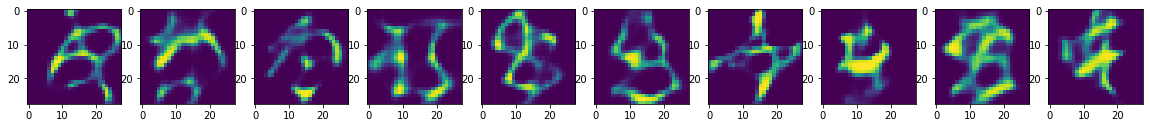

In [29]:
fig, ax = plt.subplots(ncols=10, nrows=1, figsize=(20, 5))
for i in range(10):
    ax[i].imshow(images[i])

**Yeah, so you can get more than `100%` for the homework, good luck!**